In [1]:
import warnings
warnings.filterwarnings("ignore")
from core_function import *
from Question_set import *
import pickle
import time
import os
from get_model import ANNModel as get_model_f
simu_num = 0
device="cpu"

np.random.seed(1120220054 + simu_num)
torch.manual_seed(1120220054 + simu_num)

AL_max_budget = 120
batch_active_size = 12
ini_size=200

loop_times = 5

c0=1
c1=0.39
c2=0.47
c3=0.49
c4=0.43
c5=0.45


name_of_save = "result" + str(simu_num) + ".pkl"
file_path = os.path.join(os.path.dirname(os.getcwd()), "Dataset/HAR_dataset/")
save_path = "" + name_of_save

x_test = np.loadtxt(file_path + "test/X_test.txt")
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = np.loadtxt(file_path + "test/y_test.txt")
y_test = torch.tensor(y_test, dtype=torch.int64)
y_test-=1
x_all = np.loadtxt(file_path + "train/X_train.txt")
x_all = torch.tensor(x_all, dtype=torch.float32)
y_all = np.loadtxt(file_path + "train/y_train.txt")
y_all = torch.tensor(y_all, dtype=torch.int64)
y_all-=1

x_test = (x_test-x_all.mean(dim=0))/(x_all.std(dim=0)+1e-5)
x_all = (x_all-x_all.mean(dim=0))/(x_all.std(dim=0)+1e-5)


num_classes = 6
L = num_classes
epochs_train=100
bsnum=128
bsnum2=1024
def trans_x(x, device="cpu"):
    return x.to(device)
layers_to_regularize=None

resultout = []
resultouttest = []

In [2]:
print(f'\rProgress: |{"█" * int(50 * (0)/loop_times)}{"-" * (50 - int(50 * (0)/loop_times))}| {(0)}/{loop_times} ',
                    end='')
for loop in range(loop_times):
    train_indices=torch.tensor(np.random.choice(range(x_all.shape[0]), size=ini_size, replace=False),dtype=torch.int64)
    locX = train_indices

    hyper_regular = 0.
    lr=1e-3
    #### Initial ####
    m0=get_model_f(L).to(device)
    lossre=build_model_A(model=m0,device=device,y=y_all[locX], x=x_all[locX], maxm=1,hyper_regular=hyper_regular,lr=lr,
                  epochs=epochs_train,return_loss=True, batch_size=bsnum,return_full_loss=True,trans_x=trans_x)
    set_inference_mode(m0, False)
    perf_m0=get_pred_result(model=m0, device=device, x=x_all, y=y_all, L=L,batch_size=bsnum2,trans_x=trans_x)
    mopt=get_model_f(L).to(device)
    lossopt=build_model_A(model=mopt,device=device,y=y_all, x=x_all, maxm=1,hyper_regular=hyper_regular,lr=lr,
                  epochs=epochs_train,return_loss=True, batch_size=bsnum,return_full_loss=True,trans_x=trans_x)
    set_inference_mode(mopt, False)
    perf_mopt=get_pred_result(model=mopt, device=device, x=x_all, y=y_all, L=L,batch_size=bsnum2,trans_x=trans_x)
    perf_mopt_test = get_pred_result(model=mopt, device=device, x=x_test, y=y_test, L=L, batch_size=bsnum2, trans_x=trans_x)
    del mopt

    maxm=3
    trueanswer_fun = [Q4_answer, Q1_answer, Q1_answer, Q1_answer, Q2_answer, Q2_answer]

    def simu_on_cri(question_set_use,namepro,explo_ratenow,
                    need_MCdrop=False):
        question_and_answer = None
        m_out = AL_multi_question(get_model_f=get_model_f, device=device, Xall=x_all, Yall=y_all, L=L,
                                    trueanswer_fun=trueanswer_fun, locX=locX, AL_max_budget=AL_max_budget,
                                    maxm=maxm, batch_active_size=batch_active_size, epochs=epochs_train,
                                    batch_optimize_size=bsnum,batch_infer_size=bsnum2, question_set=question_set_use,
                                    question_and_answer=question_and_answer, initial_model=m0.state_dict(),lr=lr,
                                    AL_max_iteration=10000, print_ALprocess=False, hyper_regular=hyper_regular,
                                    e_and_e=True, explo_rate=explo_ratenow, ini_quantile=0.05, threshold_len=6,
                                    trans_x=trans_x, layers_to_regularize=layers_to_regularize,
                                    namepro=namepro+": ", need_MCdrop=need_MCdrop, MCdropnum=20,
                                    xtest=x_test, ytest=y_test)
        question_and_answer = None
        m_noout = AL_multi_question(get_model_f=get_model_f, device=device, Xall=x_all, Yall=y_all, L=L,
                                      trueanswer_fun=trueanswer_fun, locX=locX, AL_max_budget=AL_max_budget,
                                      maxm=maxm, batch_active_size=batch_active_size,batch_infer_size=bsnum2, epochs=epochs_train,
                                      batch_optimize_size=bsnum, question_set=question_set_use,
                                      question_and_answer=question_and_answer, initial_model=m0.state_dict(),lr=lr,
                                      AL_max_iteration=10000, print_ALprocess=False, hyper_regular=hyper_regular,
                                      e_and_e=False, explo_rate=explo_ratenow, ini_quantile=0.05, threshold_len=6,
                                      trans_x=trans_x, layers_to_regularize=layers_to_regularize,
                                      namepro=namepro+"no: ", need_MCdrop=need_MCdrop, MCdropnum=20,
                                      xtest=x_test, ytest=y_test)
        return m_out,m_noout
    def simu_on_BADGE(namepro,explo_ratenow,temp_use_emb=False):
        m_badgenoee = AL_other_cri(get_model_f=get_model_f, device=device, Xall=x_all, Yall=y_all, L=L, locX=locX,
                               AL_max_budget=AL_max_budget, criuse=BadgeSampling, batch_active_size=batch_active_size,
                               epochs=epochs_train, batch_optimize_size=bsnum, batch_infer_size=bsnum2,initial_model=m0.state_dict(),lr=lr,
                               print_ALprocess=False, hyper_regular=hyper_regular, e_and_e=False,
                               explo_rate=explo_ratenow, ini_quantile=0.05, threshold_len=6, trans_x=trans_x,
                               layers_to_regularize=layers_to_regularize, namepro=namepro+"no: ",
                               xtest=x_test, ytest=y_test, need_embed=True, temp_use_emb=temp_use_emb)
        return m_badgenoee

    quse=0.4
    question_set = [Q4_create_GainTVq(1, c0, 0.1),
                    Q1_create_GainTVq(1, c1, 0.4,quse),
                    Q1_create_GainTVq(2, c2, 0.5,quse),
                    Q1_create_GainTVq(3, c3, 0.5,quse),
                    Q2_create_GainTVq(2, c4, 0.5,quse),
                    Q2_create_GainTVq(3, c5, 0.5,quse)]
    m_mqgtv4, m_nomqgtv4 = simu_on_cri(question_set_use=question_set, namepro="MQ GTVQ4",
                                       need_MCdrop=True,explo_ratenow=0.25)

    m_badge = simu_on_BADGE(namepro="badge",explo_ratenow=0.25,temp_use_emb=False)

    #### BALD ####
    question_setba = [Q4_create_BALD(1, 1, 0.1),
                    Q1_create_BALD(1, 1000, -1),
                    Q1_create_BALD(2, 1000, -1),
                    Q1_create_BALD(3, 1000, -1),
                    Q2_create_BALD(2, 1000, -1),
                    Q2_create_BALD(3, 1000, -1)]
    m_baout, m_banoout = simu_on_cri(question_set_use=question_setba, namepro="m_ba",
                                     need_MCdrop=True,explo_ratenow=0.25)

    #### EN ####
    question_seten = [Q4_create_entropy(1, 1, 0.1),
                    Q1_create_BALD(1, 1000, -1),
                    Q1_create_BALD(2, 1000, -1),
                    Q1_create_BALD(3, 1000, -1),
                    Q2_create_BALD(2, 1000, -1),
                    Q2_create_BALD(3, 1000, -1)]
    m_enout, m_ennoout = simu_on_cri(question_set_use=question_seten, namepro="m_en",
                                     need_MCdrop=False,explo_ratenow=0.25)

    #### VAR ####
    question_setVAR = [Q4_create_GainLinear(1, 1, 0.1),
                    Q1_create_BALD(1, 1000, -1),
                    Q1_create_BALD(2, 1000, -1),
                    Q1_create_BALD(3, 1000, -1),
                    Q2_create_BALD(2, 1000, -1),
                    Q2_create_BALD(3, 1000, -1)]
    m_varout, m_varnoout = simu_on_cri(question_set_use=question_setVAR, namepro="m_var",
                                       need_MCdrop=False,explo_ratenow=0.25)

    #### LC ####
    question_setLC = [Q4_create_leastconfident(1, 1, 0.1),
                    Q1_create_BALD(1, 1000, -1),
                    Q1_create_BALD(2, 1000, -1),
                    Q1_create_BALD(3, 1000, -1),
                    Q2_create_BALD(2, 1000, -1),
                    Q2_create_BALD(3, 1000, -1)]
    m_lcout, m_lcnoout = simu_on_cri(question_set_use=question_setLC, namepro="m_lc",
                                     need_MCdrop=False,explo_ratenow=0.25)
    #### RA ####
    question_setRA = [raAL,
                    Q1_create_BALD(1, 1000, -1),
                    Q1_create_BALD(2, 1000, -1),
                    Q1_create_BALD(3, 1000, -1),
                    Q2_create_BALD(2, 1000, -1),
                    Q2_create_BALD(3, 1000, -1)]
    m_raout, m_ranoout = simu_on_cri(question_set_use=question_setRA, namepro="m_ra",
                                     need_MCdrop=False,explo_ratenow=0.25)

    resultthis=[m_mqgtv4,m_nomqgtv4,
                m_badge,m_baout, m_banoout,
                m_enout, m_ennoout,m_varout, m_varnoout,
                m_lcout, m_lcnoout ,m_raout,m_ranoout,
                perf_mopt,perf_mopt_test]

    resultout.append(resultthis)
    print(f'\rProgress: |{"█" * int(50 * (loop + 1)/loop_times)}{"-" * (50 - int(50 * (loop + 1)/loop_times))}| {(loop + 1)}/{loop_times} ',
                    end='')

Progress: |██████████████████████████████████████████████████| 5/5 

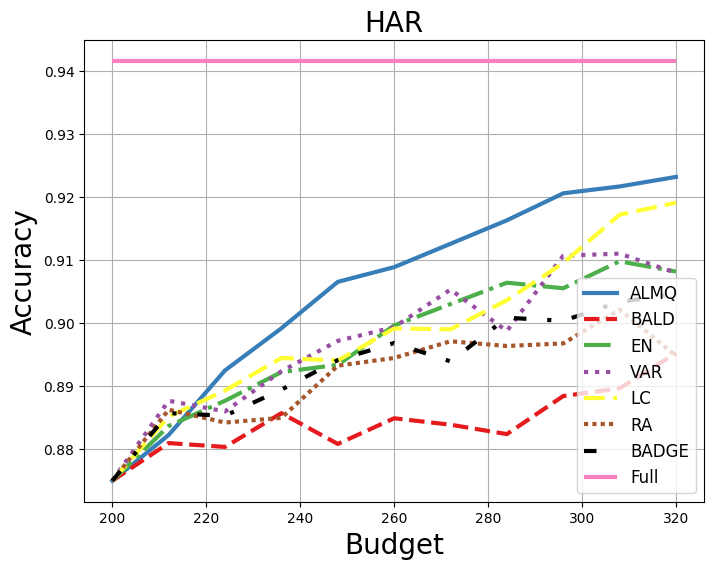

In [3]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
def plot_compare(loaded_list, Budget, batch_size=1, n0=0, lbub=None, indexuse=8, stdstart=-8,
                 usestd=True, plotfull=False, xlabel="Budget", ylabel="Accuracy", title="",
                 legend_loc="lower right", plot_best=True, need_pvalue=True):
    accall = 0
    accall2 = 0
    x = torch.arange(0, Budget + 1, 1)
    ll = torch.arange(0, Budget + 1, batch_size)
    accall = torch.empty(0, len(loaded_list[0]) - 2, len(x))
    bestacc = torch.empty(0)
    bestacc_test = torch.empty(0)

    for loop in range(len(loaded_list)):
        bestacc = torch.cat((bestacc, loaded_list[0][13][0].view(-1)))
        bestacc_test = torch.cat((bestacc_test, loaded_list[0][14][0].view(-1)))
        accallone = torch.zeros(len(loaded_list[0]) - 2, len(x))
        for ind in np.arange(len(loaded_list[0]) - 2):
            acc = loaded_list[loop][ind][:, indexuse]
            bud = loaded_list[loop][ind][:, 5]
            accnew = torch.tensor([acc[0]])
            for i in range(len(x) - 1):
                locnow = torch.where((bud > x[i]) & (bud <= x[i + 1]))[0]
                accnew = torch.cat((accnew, torch.mean(acc[locnow]).view(-1)))
            accnew = accnew.reshape(1, len(x))
            accallone[ind] = accnew
        accall = torch.cat((accall, accallone.unsqueeze(0)), 0)
    yall = accall.mean(dim=0)
    stdall = accall.std(dim=0)

    def getplot(x, y, ll, label, color, linestyle, linewidth=3, std=None):
        # y=y-1*std
        plt.plot(x[ll] + n0, y[ll], label=label, color=color, linestyle=linestyle, linewidth=linewidth)
        if (std is not None) and (usestd):
            co = 1.96 / (len(loaded_list) - 1) ** 0.5
            for locnow in ll[stdstart:]:
                plt.plot([x[locnow] + n0, x[locnow] + n0], [y[locnow] - co * std[locnow], y[locnow] + co * std[locnow]],
                         color=color, linestyle="-", linewidth=linewidth / 1.2)

    colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3',
              '#ffff33', '#a65628', '#000000']
    linestyles = ['-', '--', '-.', ':', (0, (5, 2)), (0, (1, 1)), (0, (3, 5, 1, 5)), (0, (2, 2, 10, 2))]
    getplot(x, yall[0], ll, label='ALMQ', color=colors[0], linestyle=linestyles[0], linewidth=3, std=stdall[0])
    getplot(x, yall[3], ll, label='BALD', color=colors[1], linestyle=linestyles[1], linewidth=3, std=stdall[3])
    getplot(x, yall[5], ll, label='EN', color=colors[2], linestyle=linestyles[2], linewidth=3, std=stdall[5])
    getplot(x, yall[7], ll, label='VAR', color=colors[3], linestyle=linestyles[3], linewidth=3, std=stdall[7])
    getplot(x, yall[9], ll, label='LC', color=colors[4], linestyle=linestyles[4], linewidth=3, std=stdall[9])
    getplot(x, yall[11], ll, label='RA', color=colors[5], linestyle=linestyles[5], linewidth=3, std=stdall[11])
    getplot(x, yall[2], ll, label='BADGE', color=colors[6], linestyle=linestyles[6], linewidth=3, std=stdall[2])

    if plot_best and indexuse == 8:
        plt.hlines(y=bestacc_test.mean(), xmin=x.min() + n0, xmax=x.max() + n0, colors='#f781bf',
                   linewidth=3, label="Full", linestyle='-')
    if plot_best and indexuse == 0:
        plt.hlines(y=bestacc.mean(), xmin=x.min() + n0, xmax=x.max() + n0, colors='#f781bf',
                   linewidth=3, label="Full", linestyle='-')
    if lbub is not None:
        plt.ylim(lbub[0], lbub[1])
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.grid(True)


plt.figure(figsize=(8, 6))
plot_compare(loaded_list=resultout, Budget=120,batch_size=12,n0=200, lbub=None,
             indexuse=8, stdstart=0, usestd=False, plotfull=False, xlabel="Budget",
             ylabel="Accuracy", title="HAR",
             plot_best=True, need_pvalue=True)
plt.legend(fontsize=12, loc="lower right")
plt.show()

